In [1]:
###Trackpy Analysis from Cellpose Masks###

###This notebook extracts cell centroids from Cellpose output masks and tracks them using Trackpy. it applies a filter for the maximum number of particles per frame and a filter for min number of frames to reduce noise. ###

In [1]:
# Imports #
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.measure import regionprops, label
import matplotlib.pyplot as plt
import trackpy as tp
from tqdm import tqdm
import subprocess
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
import imageio
from IPython.display import Video


In [2]:

czi_filename = '/mnt/storage_sda/Projects/imaging_data/mix_dilution_FibronectinPDK_24hr_5x_1x_JDF_9may2025-Scene-45-F10-F10/'
mask_dir = os.path.join(czi_filename, 'cellpose_outputs') #location of masks and flows
image_dir = os.path.join(czi_filename, 'enhanced_rgb_frames') #location of rbg frams

# Filtering thresholds for linking. it removes tracks that are likely due to noise and not actual cells
min_duration = 5 #number of frames that the track must occupy in order to be considered a valid track


In [3]:
# Load and Analyze Region Properties #
# loads the mask/image files and saves difference properties calculated in regionprops() so they can be accessed for filtering if necessary. 
# the full data is saved in full_df
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('_mask.tif')])
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png') or f.endswith('.tif')])

all_points = []

for frame_num, (mask_fname, image_fname) in enumerate(tqdm(zip(mask_files, image_files), total=len(mask_files))):
    mask = imread(os.path.join(mask_dir, mask_fname))
    image = imread(os.path.join(image_dir, image_fname))
    
    if image.ndim == 3:
        image = image.mean(axis=-1)

    regions = regionprops(label(mask), intensity_image=image)

    for r in regions:
        y, x = r.centroid
        all_points.append({
            'frame': frame_num,
            'y': y,
            'x': x,
            'area': r.area,
            'solidity': r.solidity,
            'equivalent_diameter': r.equivalent_diameter,
            'mean_intensity': r.mean_intensity,
            'max_intensity': r.max_intensity,
            'min_intensity': r.min_intensity,
            'orientation': r.orientation,
            'eccentricity': r.eccentricity,
            'perimeter': r.perimeter,
            'major_axis_length': r.major_axis_length,
            'minor_axis_length': r.minor_axis_length
        })

full_df = pd.DataFrame(all_points)


100%|█████████████████████████████████████████████████████████████████████████████| 289/289 [02:14<00:00,  2.15it/s]


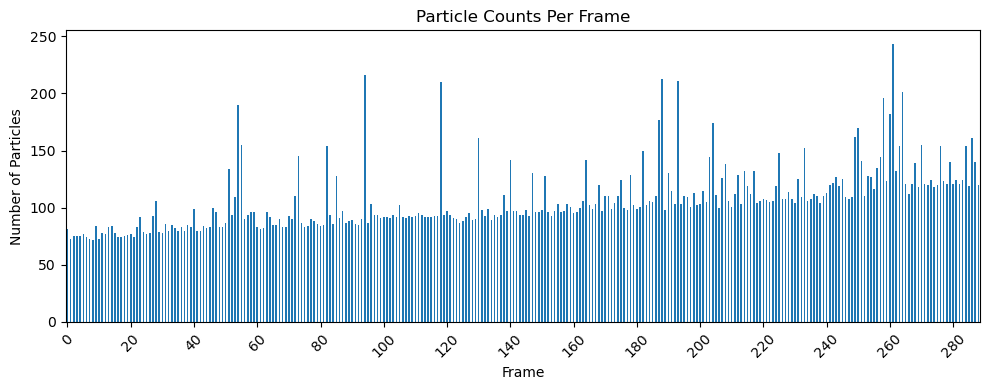

In [4]:
# Visualize particle counts per frame before filtering
frame_counts = full_df['frame'].value_counts().sort_index()

plt.figure(figsize=(10, 4))
ax = frame_counts.plot(kind='bar')

# Set x-axis ticks to every 20 frames
xticks = np.arange(0, len(frame_counts), 20)
ax.set_xticks(xticks)
ax.set_xticklabels(frame_counts.index[xticks], rotation=45)

plt.xlabel('Frame')
plt.ylabel('Number of Particles')
plt.title('Particle Counts Per Frame')
plt.tight_layout()
plt.show()

In [5]:
# filter the df based on distance between consecutive frames. this allows us to filter out large sections of noise in the data and prevent Trackpy from throwing a SubnetOversizeException

# max allowed distance between detections in consecutive frames
max_distance = 15

rows_to_keep = []

df_sorted = full_df.sort_values('frame')

for f in sorted(df_sorted['frame'].unique()):
    df_curr = df_sorted[df_sorted['frame'] == f]

    if f == 0:
        # Always keep first frame
        rows_to_keep.append(df_curr)
        continue

    df_prev = df_sorted[df_sorted['frame'] == f - 1]

    # Skip if no data in previous frame
    if df_prev.empty:
        continue

    prev_coords = df_prev[['x', 'y']].values
    curr_coords = df_curr[['x', 'y']].values

    # Build KD-tree and query distances
    tree = cKDTree(prev_coords)
    distances, _ = tree.query(curr_coords, k=1)

    # Keep only those within the distance threshold
    df_curr_filtered = df_curr[distances <= max_distance]
    rows_to_keep.append(df_curr_filtered)

# Concatenate all kept rows
filtered_df = pd.concat(rows_to_keep, ignore_index=True)
# Count rows before and after filtering
original_count = len(full_df)
filtered_count = len(filtered_df)
removed_count = original_count - filtered_count

print(f"Rows kept: {filtered_count}")
print(f"Rows filtered out: {removed_count}")



Rows kept: 27000
Rows filtered out: 3874


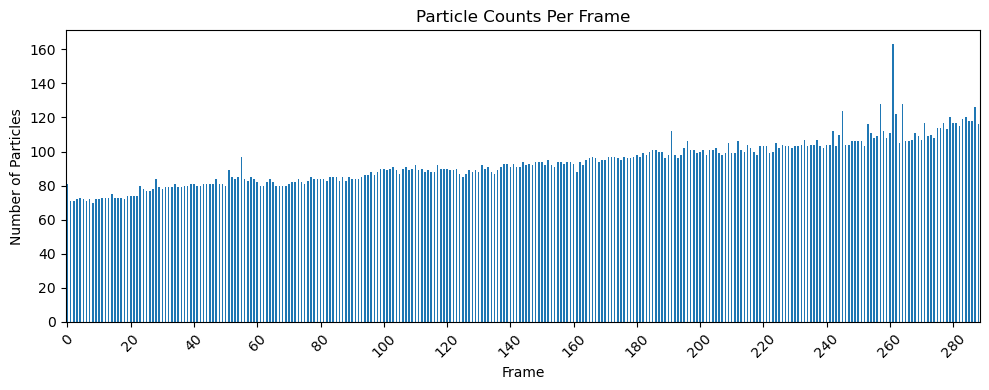

In [6]:
# Visualize particle counts per frame after filtering
# Visualize particle counts per frame before filtering
frame_counts = filtered_df['frame'].value_counts().sort_index()

plt.figure(figsize=(10, 4))
ax = frame_counts.plot(kind='bar')

# Set x-axis ticks to every 20 frames
xticks = np.arange(0, len(frame_counts), 20)
ax.set_xticks(xticks)
ax.set_xticklabels(frame_counts.index[xticks], rotation=45)

plt.xlabel('Frame')
plt.ylabel('Number of Particles')
plt.title('Particle Counts Per Frame')
plt.tight_layout()
plt.show()

In [19]:
# Compute absolute percent change between frame counts
frame_deltas_pct = frame_counts.pct_change().abs()
frame_deltas_pct.iloc[0] = 0  # or np.nan_to_num(..., nan=0)

# Set your percentage threshold (e.g., 0.25 means 25%)
percent_threshold = 0.50

# Keep frames where the percent change is less than or equal to threshold
valid_frames = frame_deltas_pct[frame_deltas_pct <= percent_threshold].index

# Filter the DataFrame
df_new = filtered_df[filtered_df['frame'].isin(valid_frames)].copy()

removed_frames = len(frame_counts) - len(valid_frames)
print(f"Frames kept: {len(valid_frames)}")
print(f"Frames removed: {removed_frames}")


Frames kept: 289
Frames removed: 0


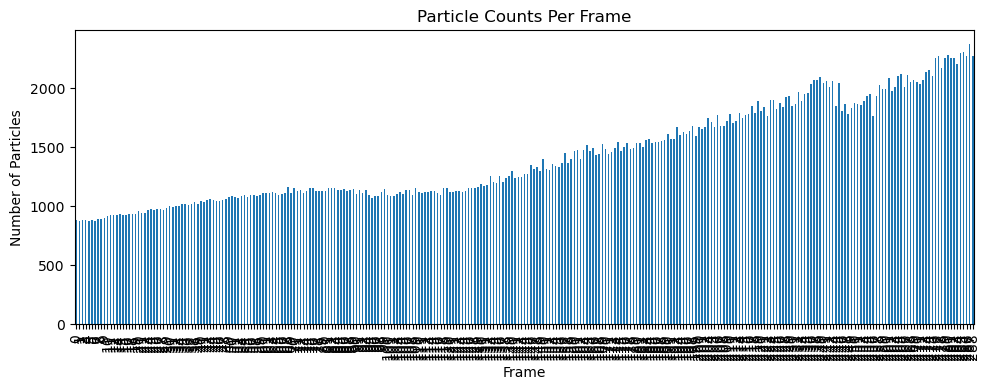

frame
287    2373
285    2307
284    2301
280    2284
288    2278
Name: count, dtype: int64


In [20]:
# Visualize particle counts per frame after second filter
frame_counts = df_new['frame'].value_counts().sort_index()
plt.figure(figsize=(10, 4))
frame_counts.plot(kind='bar')
plt.xlabel('Frame')
plt.ylabel('Number of Particles')
plt.title('Particle Counts Per Frame')
plt.tight_layout()
plt.show()

print(frame_counts.sort_values(ascending=False).head())

In [21]:
#create links with double filtered df
linked = tp.link_df(df_new, search_range=15, memory=2)
os.makedirs(os.path.join(czi_filename, 'tracks'), exist_ok=True)
linked.to_csv(os.path.join(czi_filename, 'tracks', 'linked_tracks.csv'), index=False)

Frame 288: 2278 trajectories present.


In [22]:
#record track stats, can be used in later filtering
def mean_step_disp(traj):
    coords = traj[['x', 'y']].values
    steps = np.linalg.norm(coords[1:] - coords[:-1], axis=1)
    return np.mean(steps) if len(steps) > 0 else 0

track_stats = linked.groupby('particle').agg(
    start_frame=('frame', 'min'),
    end_frame=('frame', 'max'),
    duration=('frame', lambda x: x.max() - x.min() + 1),
    start_x=('x', 'first'),
    start_y=('y', 'first'),
    end_x=('x', 'last'),
    end_y=('y', 'last')
)

track_stats['displacement'] = np.sqrt((track_stats['end_x'] - track_stats['start_x'])**2 + 
                                      (track_stats['end_y'] - track_stats['start_y'])**2)
track_stats['mean_step_disp'] = linked.groupby('particle').apply(mean_step_disp)



/tmp/ipykernel_25041/3787143700.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  track_stats['mean_step_disp'] = linked.groupby('particle').apply(mean_step_disp)


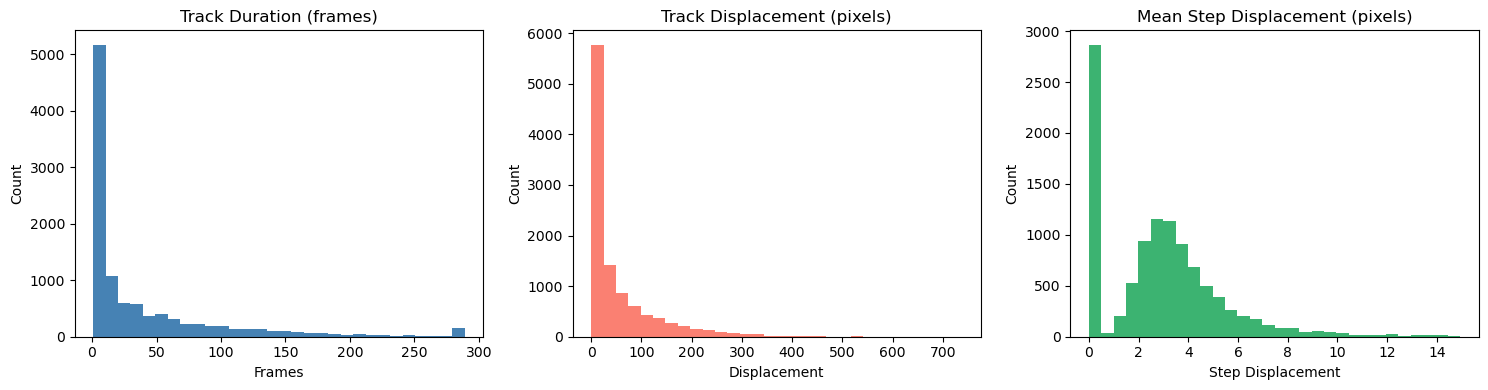

Kept 5598 out of 10608 tracks.


In [23]:
# Visualize distributions of track statistics
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].hist(track_stats['duration'], bins=30, color='steelblue')
axs[0].set_title('Track Duration (frames)')
axs[0].set_xlabel('Frames')
axs[0].set_ylabel('Count')

axs[1].hist(track_stats['displacement'], bins=30, color='salmon')
axs[1].set_title('Track Displacement (pixels)')
axs[1].set_xlabel('Displacement')
axs[1].set_ylabel('Count')

axs[2].hist(track_stats['mean_step_disp'], bins=30, color='mediumseagreen')
axs[2].set_title('Mean Step Displacement (pixels)')
axs[2].set_xlabel('Step Displacement')
axs[2].set_ylabel('Count')
plt.tight_layout()
plt.show()

#removed tracks that are too short
valid_tracks = track_stats[(track_stats['duration'] >= 10)].index

filtered_linked = linked[linked['particle'].isin(valid_tracks)].copy()
filtered_linked.to_csv(os.path.join(czi_filename, 'tracks', 'linked_tracks_filtered.csv'), index=False)

print(f"Kept {len(valid_tracks)} out of {len(track_stats)} tracks.")

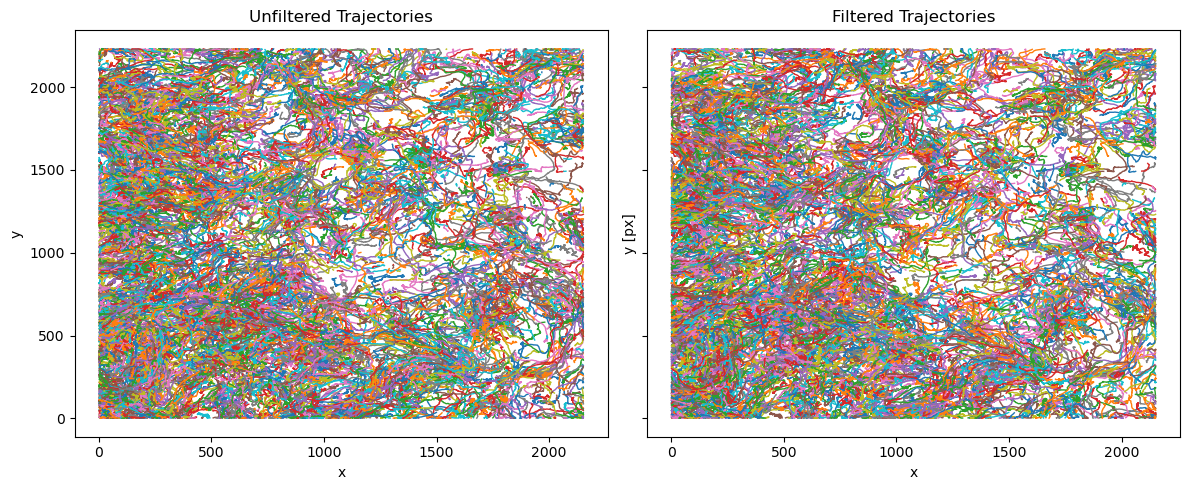

In [24]:
#plot trajectories
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

#unfiltered
tp.plot_traj(linked, ax=axes[0])
axes[0].invert_yaxis()
axes[0].set_title('Unfiltered Trajectories')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')

#filterec
tp.plot_traj(filtered_linked, ax=axes[1])
axes[1].invert_yaxis()
axes[1].set_title('Filtered Trajectories')
axes[1].set_xlabel('x')

#diplay side by side
plt.tight_layout()
plt.show()

In [ ]:
#visualization and movie frame gen for both filtered and unfilter links, so the resulting movies can be compared
for link_type, link_df, label in [
    ('filtered', filtered_linked, 'Filtered'),
    ('unfiltered', linked, 'Unfiltered')
]:
    track_frame_dir = os.path.join(czi_filename, 'tracks', f'track_frames_{link_type}')
    os.makedirs(track_frame_dir, exist_ok=True)
    cmap = plt.get_cmap('tab10')

    sample_img = imread(os.path.join(image_dir, image_files[0]))
    height, width = sample_img.shape[:2]
    tail_length = 288

    for fnum, img_name in enumerate(tqdm(image_files, desc=f"Rendering {label} frames")):
        vis = imread(os.path.join(image_dir, img_name))
        if vis.ndim == 3:
            vis = vis.mean(axis=-1)
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(vis, cmap='gray', vmin=vis.min(), vmax=vis.max())
        ax.set_axis_off()

        for pid in link_df['particle'].unique():
            traj = link_df[link_df['particle'] == pid]
            tail = traj[(traj['frame'] <= fnum) & (traj['frame'] > fnum - tail_length)]
            if len(tail) > 1:
                ax.plot(tail['x'], tail['y'], '-', linewidth=2, alpha=0.8, color=cmap(int(pid) % 10))

        fig.savefig(os.path.join(track_frame_dir, f"{fnum:04d}.png"), dpi=100, bbox_inches='tight', pad_inches=0)
        plt.close(fig)

Rendering Filtered frames:  20%|██████████                                         | 57/289 [05:53<23:44,  6.14s/it]

In [22]:
# === 8. FFmpeg Movie Compilation ===
for link_type in ['filtered', 'unfiltered']:
    track_frame_dir = os.path.join(czi_filename, 'tracks', f'track_frames_{link_type}')
    output_video = os.path.join(czi_filename, 'tracks', f'track_overlay_{link_type}.mp4')
    input_pattern = os.path.join(track_frame_dir, '%04d.png')

    ffmpeg_cmd = [
        'ffmpeg', '-y', '-framerate', '10', '-i', input_pattern,
        '-vf', 'pad=ceil(iw/2)*2:ceil(ih/2)*2',
        '-c:v', 'libx264', '-pix_fmt', 'yuv420p', output_video
    ]

    print(f"Running FFmpeg for {link_type}...")
    subprocess.run(ffmpeg_cmd, check=True)
    print(f"Saved movie to {output_video}")

output_video_filtered = os.path.join(czi_filename, 'tracks', f'track_overlay_filtered.mp4')
output_video_unfiltered = os.path.join(czi_filename, 'tracks', f'track_overlay_unfiltered.mp4')


Running FFmpeg for filtered...


ffmpeg version 4.4 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 9.4.0 (GCC)
  configuration: --prefix=/home/mars/anaconda3/envs/snyder --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1635121324509/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-demuxer=dash --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libvpx --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1635121324509/_build_env/bin/pkg-config
  libavutil      56. 70.100 / 56. 70.100
  libavcodec     58.134.100 / 58.134.100
  libavformat    58. 76.100 / 58. 76.100
  libavdevice    58. 13.100 / 58. 13.100
  libavfilter     7.110.100 /  7.110.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  9.100 /  5. 

Saved movie to /mnt/storage_sda/Projects/imaging_data/mix_dilution_FibronectinPDK_24hr_5x_1x_JDF_9may2025-Scene-29-E3-E03/tracks/track_overlay_filtered.mp4
Running FFmpeg for unfiltered...


Input #0, image2, from '/mnt/storage_sda/Projects/imaging_data/mix_dilution_FibronectinPDK_24hr_5x_1x_JDF_9may2025-Scene-29-E3-E03/tracks/track_frames_unfiltered/%04d.png':
  Duration: 00:00:28.90, start: 0.000000, bitrate: N/A
  Stream #0:0: Video: png, rgba(pc), 445x462 [SAR 3937:3937 DAR 445:462], 10 fps, 10 tbr, 10 tbn, 10 tbc
Stream mapping:
  Stream #0:0 -> #0:0 (png (native) -> h264 (libx264))
Press [q] to stop, [?] for help
[libx264 @ 0x64b2fbcda280] using SAR=1/1
[libx264 @ 0x64b2fbcda280] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x64b2fbcda280] profile High, level 2.2, 4:2:0, 8-bit
[libx264 @ 0x64b2fbcda280] 264 - core 161 r3030M 8bd6d28 - H.264/MPEG-4 AVC codec - Copyleft 2003-2020 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=14 lookahe

Saved movie to /mnt/storage_sda/Projects/imaging_data/mix_dilution_FibronectinPDK_24hr_5x_1x_JDF_9may2025-Scene-29-E3-E03/tracks/track_overlay_unfiltered.mp4


frame=  289 fps=217 q=-1.0 Lsize=     721kB time=00:00:28.60 bitrate= 206.5kbits/s speed=21.5x    
video:717kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.557648%
[libx264 @ 0x64b2fbcda280] frame I:2     Avg QP:17.30  size: 14466
[libx264 @ 0x64b2fbcda280] frame P:104   Avg QP:19.51  size:  3424
[libx264 @ 0x64b2fbcda280] frame B:183   Avg QP:20.67  size:  1903
[libx264 @ 0x64b2fbcda280] consecutive B-frames:  7.6% 15.9% 23.9% 52.6%
[libx264 @ 0x64b2fbcda280] mb I  I16..4: 27.5% 41.5% 31.0%
[libx264 @ 0x64b2fbcda280] mb P  I16..4:  2.1%  4.2%  0.4%  P16..4: 48.3%  7.7% 10.7%  0.0%  0.0%    skip:26.8%
[libx264 @ 0x64b2fbcda280] mb B  I16..4:  1.4%  1.9%  0.1%  B16..8: 44.4%  4.2%  1.5%  direct: 9.7%  skip:36.8%  L0:52.3% L1:44.0% BI: 3.6%
[libx264 @ 0x64b2fbcda280] 8x8 transform intra:57.0% inter:76.8%
[libx264 @ 0x64b2fbcda280] coded y,uvDC,uvAC intra: 40.7% 3.6% 2.4% inter: 27.6% 2.6% 2.2%
[libx264 @ 0x64b2fbcda280] i16 v,h,dc,p: 37% 21% 12% 31%
[lib

In [28]:
import imageio
import os

# Path to folder containing your images
image_dir = os.path.join(czi_filename, 'enhanced_rgb_frames')

# Path to output directory and movie file
video_dir = os.path.join(czi_filename, 'videos')
os.makedirs(video_dir, exist_ok=True)  # create if not exist

output_movie = os.path.join(video_dir, 'original_movie.mp4')

# Get all image filenames sorted
image_files = sorted([
    os.path.join(image_dir, fname)
    for fname in os.listdir(image_dir)
    if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))
])

# Create video writer
with imageio.get_writer(output_movie, fps=10, codec='libx264', format='ffmpeg') as writer:
    for i, file in enumerate(image_files):
        image = imageio.imread(file)
        writer.append_data(image)

print(f"MP4 movie saved as: {output_movie}")


/tmp/ipykernel_6899/43331797.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(file)
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2154, 2233) to (2160, 2240) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x56c32641f080] Warning: data is not aligned! This can lead to a speed loss


MP4 movie saved as: /mnt/storage_sda/Projects/imaging_data/mix_dilution_FibronectinPDK_24hr_5x_1x_JDF_9may2025-Scene-29-E3-E03/videos/original_movie.mp4
